# Setup

In [3]:
# import packages
import pandas as pd
import plotly.graph_objects as go
import nfl_data_py as nfl  # load data

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Weekly Data

In [36]:
# Get normal distribution parameters for a player
def player_dist(weekly_df, player_name):
    # Get each week's data
    player_weeks_df = weekly_df[weekly_df['player_display_name'] == player_name]
    
    # Number of games played by the player.
    n_games = len(player_weeks_df.index)
    
    # Convert to numpy
    player_weeks_np = player_weeks_df[['fantasy_points_ppr']].to_numpy()
        
    # Average and variance
    avg = np.average(player_weeks_np)
    s2 = np.var(player_weeks_np)
    
    return avg, s2, n_games

def sample_ppr_repl_team(position_replacements, lineup, N):
    n_lineup_spots = len(lineup)
    
    # Sample scores
    ppr_team_scores = None
    for i in range(n_lineup_spots):
        # Get the position from the lineup
        pos = lineup[i]

        # Get position distribution parameters
        mean = position_replacements[pos]['avg']
        std = np.sqrt(position_replacements[pos]['s2'])

        # Sample the position
        pos_samples = np.random.default_rng().normal(mean, std, N)

        # Add to the scores
        if ppr_team_scores is None:
            ppr_team_scores = pos_samples
        else:
            ppr_team_scores += pos_samples
    
    return ppr_team_scores

def sample_player(weekly_df, player_name, N):
    # Get player distribution
    mu, s2, n_games = player_dist(weekly_df, player_name)
        
    # Convert s2 to std. dev
    std = np.sqrt(s2)
    player_samples = np.random.default_rng().normal(mu, std, N)
    
    # Ensure player scores are >= 0
    player_samples[player_samples < 0] = 0.0
    
    return player_samples

In [9]:
def plot_samples(scores, mu, sigma):
    count, bins, ignored = plt.hist(scores, 30, density=True)
    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')

    plt.show()

In [10]:
weekly_data = nfl.import_weekly_data([2022])

Downcasting floats.


In [11]:
weekly_data.head()

,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,...,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
0,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,TB,2022,1,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,10.38,10.38
1,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,TB,2022,2,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,9.40,9.40
2,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,TB,2022,3,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,14.74,14.74
3,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,TB,2022,4,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,25.40,25.40
4,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,TB,2022,5,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,19.74,19.74


In [12]:
weekly_data['position'].unique()

array(['QB', 'P', 'TE', 'WR', 'RB', 'ILB', 'FB', 'T', 'FS', 'SS', 'OLB',
       'CB'], dtype=object)

In [13]:
# only show data from week 17 and earlier (fantasy regular season and playoffs)
weekly_data = weekly_data[weekly_data['week'] <= 17]

In [14]:
# Get total fantasy points for each player via aggregation
week_agg = (
    weekly_data.groupby(["player_display_name", "position"], as_index=False)
    .agg({"fantasy_points_ppr": "sum"})
)

In [15]:
week_agg

,player_display_name,position,fantasy_points_ppr
0,A.J. Brown,WR,286.100006
1,A.J. Dillon,RB,164.300003
2,A.J. Green,WR,43.500000
3,Aaron Jones,RB,240.800003
4,Aaron Rodgers,QB,228.000000
...,...,...,...
597,Zack Moss,RB,43.400002
598,Zamir White,RB,6.600000
599,Zander Horvath,RB,18.600000
600,Zay Jones,WR,192.000000


In [16]:
positions = ["QB", "RB", "WR", "TE"] # Still need a way to get K and D/ST data.
position_dfs = {}

# Separate results by position
for p in positions:
    position_dfs[p] = week_agg[week_agg['position'] == p]
    position_dfs[p] = position_dfs[p].sort_values('fantasy_points_ppr', ascending=False)

In [17]:
# Example
position_dfs['TE'].head(25)

,player_display_name,position,fantasy_points_ppr
552,Travis Kelce,TE,306.500000
528,T.J. Hockenson,TE,212.800003
392,Mark Andrews,TE,190.500000
208,George Kittle,TE,181.599991
197,Evan Engram,TE,170.199997
457,Pat Freiermuth,TE,148.199997
577,Tyler Higbee,TE,144.699997
534,Taysom Hill,TE,142.300003
127,Dalton Schultz,TE,135.399994
326,Juwan Johnson,TE,131.699997


In [18]:
# compute replacement level player for each position group
# Lineup format: QB, 2x RB, 2x WR, 1x TE, 1x FLEX, D/ST, K
#
# We will define replacement level as the average player for a 
# given position who would not be on a starting lineup on a team
# For example, the 13th best QB would not make the starting lineup
# in a 12 team league.
# 
#
# Replacement level QB: average pts. for ranks #13-24
# Replacement level RB: average pts. for ranks #25-48
# Replacement level WR: average pts. for ranks #25-48
# Replacement level TE: average pts. for ranks #13-24
# Replacement level FLEX: since FLEX is RB/WR/TE, use the position WAR.
#
# Zero-index and upper bound is not inclusive
pos_ranges = {
    'QB': [12, 24],
    'RB': [24, 48],
    'WR': [24, 48],
    'TE': [12, 24]
}

position_replacements = {}

for p in positions:
    pos_range = position_dfs[p].iloc[pos_ranges[p][0]:pos_ranges[p][1]]
    
    pos_avg = []
    pos_s2 = []
    for i, row in pos_range.iterrows():
        name = row['player_display_name']
        avg, s2, _ = player_dist(weekly_data, name)
#         print(f"{name} - Avg: {avg}, s2: {s2}")
        pos_avg.append(avg)
        pos_s2.append(s2)
        
    position_replacements[p] = {}
    position_replacements[p]['avg'] = np.average(pos_avg)
    position_replacements[p]['s2'] = np.average(pos_s2)

In [19]:
# Compute FLEX as a weighted average of RB, WR and TE
flex_options = ['RB', 'WR', 'TE']
flex_weights = [0.4, 0.5, 0.1]

flex_avg = 0
flex_s2 = 0
for i in range(len(flex_options)):
    avg = position_replacements[flex_options[i]]['avg']
    s2 = position_replacements[flex_options[i]]['s2']
    
    flex_avg += avg * flex_weights[i]
    flex_s2 += s2 * flex_weights[i]
    
position_replacements['FLEX'] = {
    'avg': flex_avg,
    's2': flex_s2
}

In [20]:
# Manual augmentation of K and D/ST
position_replacements['K'] = {
    'avg': 6,
    's2': 16
}
position_replacements['DST'] = {
    'avg': 5,
    's2': 25
}

In [21]:
position_replacements

{'QB': {'avg': 15.393757, 's2': 47.682476},
 'RB': {'avg': 9.839898, 's2': 45.30572},
 'WR': {'avg': 11.436713, 's2': 44.914127},
 'TE': {'avg': 7.9480615, 's2': 26.334734},
 'FLEX': {'avg': 10.449121999740601, 's2': 43.21282558441162},
 'K': {'avg': 6, 's2': 16},
 'DST': {'avg': 5, 's2': 25}}

In [22]:
# Compute a PPR team as a normal distribution using sampling
N = 1000

# Lineup for the team
lineup = ['QB', 'RB', 'RB', 'WR', 'WR', 'TE', 'FLEX', 'DST', 'K']

# Sample the team
ppr_repl_team_scores = sample_ppr_repl_team(position_replacements, lineup, N)

In [23]:
repl_avg = np.average(ppr_repl_team_scores)
repl_sigma = np.std(ppr_repl_team_scores)
print(f"Replacement level team - AVG: {repl_avg} - SIGMA: {repl_sigma}")

Replacement level team - AVG: 88.07504316805388 - SIGMA: 18.918476261725605


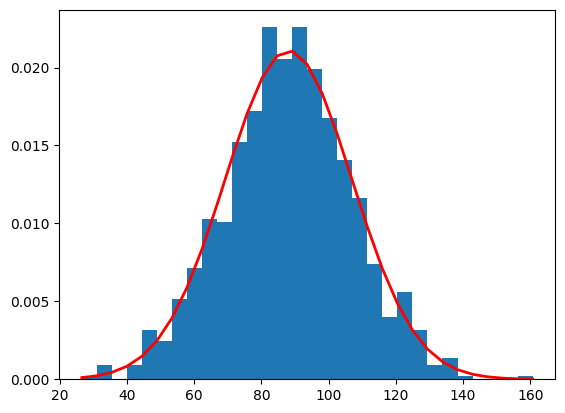

In [24]:
plot_samples(ppr_repl_team_scores, repl_avg, repl_sigma)

# WAR Ranks

In [43]:
player_list_df = week_agg
PPR_LINEUP = ['QB', 'RB', 'RB', 'WR', 'WR', 'TE', 'FLEX', 'DST', 'K']
N = 10000
MIN_GAMES = 3

In [44]:
war_data = {'player_display_name':[], 'position': [], 'n_games':[], 'mu': [], 'sigma': [], 'wpa': [], 'war': []}

for i, row in player_list_df.iterrows():
    # Copy the lineup explicitly since we will modify it.
    mod_lineup = list.copy(PPR_LINEUP)
    
    # Get player info
    name = row['player_display_name']
    pos = row['position']
    p_mu, p_sigma, p_games = player_dist(weekly_data, name)
    
    # Remove position from lineup if it exists, or if the player did not play at least 3 games
    if pos not in PPR_LINEUP or p_games < MIN_GAMES:
        continue
    mod_lineup.remove(pos)
    
    # Sample a replacement team's score with this player added
    mod_team_scores = sample_ppr_repl_team(position_replacements, mod_lineup, N)
    player_samples = sample_player(weekly_data, name, N)
    player_team_scores = mod_team_scores + player_samples
    
    # Get this fictitious team's normal distribution parameters
    player_team_avg = np.average(player_team_scores)
    player_team_sigma = np.std(player_team_scores)
    
    # Compute WPA and WAR
    player_wpa = norm.cdf(player_team_avg, loc=repl_avg, scale=repl_sigma) - 0.5
    player_war = p_games * player_wpa

    # Update the dictionary
    war_data['player_display_name'].append(name)
    war_data['position'].append(pos)
    war_data['n_games'].append(p_games)
    war_data['mu'].append(p_mu)
    war_data['sigma'].append(np.sqrt(p_sigma))
    war_data['wpa'].append(player_wpa)
    war_data['war'].append(player_war)


In [45]:
war_df = pd.DataFrame(war_data)

In [46]:
war_df = war_df.sort_values(by=['war'], ascending=False, ignore_index=True)
pd.set_option('display.max_rows', 500)
war_df.head(50)

,player_display_name,position,n_games,mu,sigma,wpa,war
0,Austin Ekeler,RB,16,22.731251,8.369044,0.240691,3.851057
1,Christian McCaffrey,RB,16,21.216249,8.457760,0.220734,3.531742
2,Justin Jefferson,WR,16,22.553749,11.495086,0.210595,3.369527
3,Travis Kelce,TE,16,19.156250,7.589958,0.208397,3.334356
4,Josh Jacobs,RB,16,20.081249,11.605990,0.205373,3.285969
5,Patrick Mahomes,QB,16,25.151249,5.977345,0.181184,2.898939
6,Tyreek Hill,WR,16,21.056250,8.943710,0.178505,2.856079
7,Jalen Hurts,QB,14,26.398573,5.855700,0.202865,2.840106
8,Davante Adams,WR,16,20.200001,11.897794,0.169787,2.716588
9,Derrick Henry,RB,15,19.264000,8.395094,0.177853,2.667794


In [64]:
war_df.to_csv("player_war.csv", index=False)

# Position Breakdown

In [103]:
def plot_position_war(df, pos, n_show = None):
    war_np = df["war"].to_numpy()
    n_players =  len(df.index)
    
    if n_show is not None:
        n_players = n_show
        war_np = war_np[0:n_show]
    
    ranks_np = np.linspace(1, n_players, n_players)
    
    plt.figure()
    plt.grid()
    plt.scatter(ranks_np, war_np)
    plt.xlabel("Ranks")
    plt.ylabel("WAR")
    plt.title(f"{pos} WAR Rankings")
    plt.show()

In [53]:
position_queries = ['QB', 'RB', 'WR', 'TE']

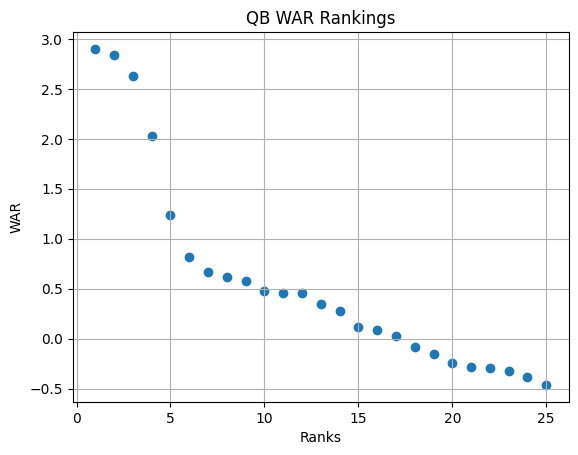

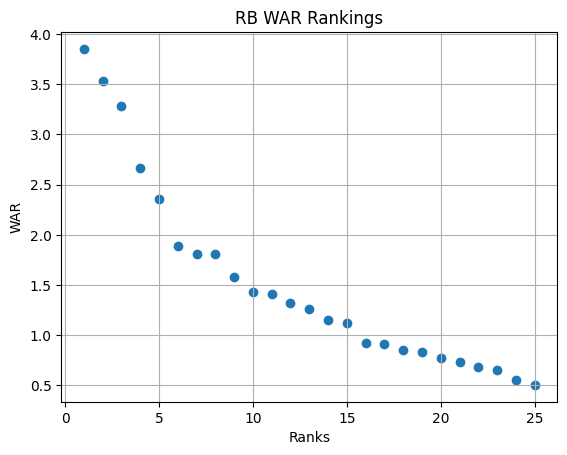

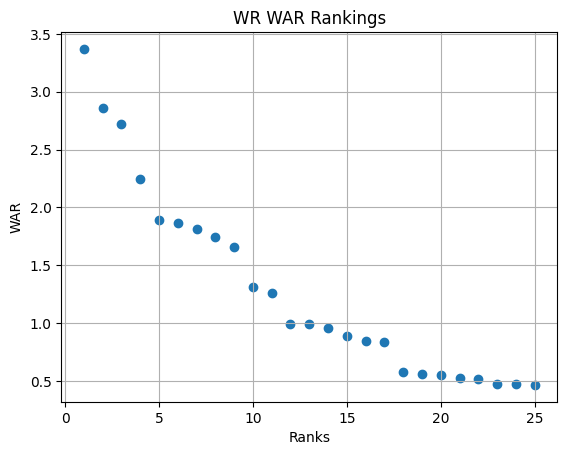

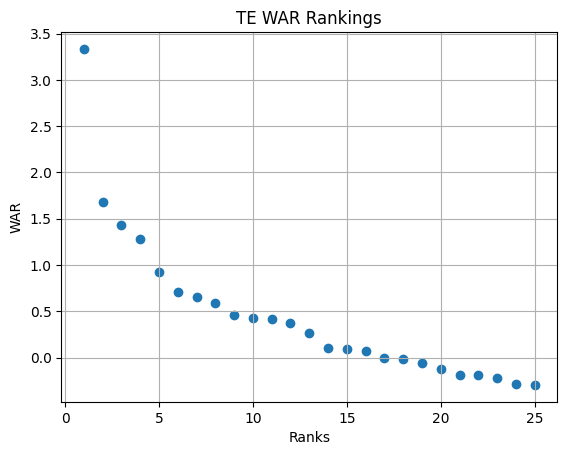

In [104]:
for i, pos in enumerate(position_queries):
    pos_war_df = war_df[war_df['position'] == pos]
    
    plot_position_war(pos_war_df, pos, 25)

# Basic WAR Draft Strategy

Given perfect knowledge, a good draft strategy would be to simply pick the highest WAR player available to fill out the starting lineup, and then pick best WAR available for the remainder of the draft (while picking K and D/ST at some point). 

This isn't guaranteed to be the best strategy - a rigorous Monte-Carlo Tree Search (MCTS) would likely be needed to reveal a better strategy for this multiplayer game theory problem. So instead, we will see how this naive strategy would have performed for a 12 team PPR draft

In [105]:
N_TEAMS = 12
teams = []

rules = {
    'QB': {
        'min': 1
    },
    'RB': 
    {
        'min': 2
    },
    'WR': 
    {
        'min': 2
    },
    'TE': 
    {
        'min': 1
    }
    
}

# Build the list of empty teams
for i in range(N_TEAMS):
    teams.append({
        'QB': [None],
        'RB': [None, None, None],
        'WR': [None, None, None],
        'TE': [None, None]
    })

# Do a snake draft
N_ROUNDS = 7 # 7 rounds to fill out the relevant parts of the starting lineup

# Save the draft results
draft_order = {
    'pick': [],
    'player_display_name': [],
    'war': []
}

# Maintain a copy of the WAR dataframe. This is sorted by WAR from highest to lowest.
draftable_players = pd.read_csv("player_war.csv")

# Round / team indexing
cur_round = 1
team_idx = 0
for i in range(N_TEAMS * N_ROUNDS):
    # Drafted player information
    player_info = {
        'name': None,
        'war': None
    }
    found_player = False
    
    # Find the best WAR player who can fill an open spot on this team's starting lineup.
    for j, row in draftable_players.iterrows():
        pos = row['position']
        for k in range(len(teams[team_idx][pos])):
            # Draft the player if the position group is not at its minimum, or this is the last round
            if ((teams[team_idx][pos][k] is None) and (k < rules[pos]['min'] or cur_round == N_ROUNDS)):
                player_info['name'] = row['player_display_name']
                player_info['war'] = row['war']
                teams[team_idx][pos][k] = player_info
                found_player = True
                break

        # If a player has been drafted, stop searching
        if found_player is True:
            break
    
    # Register the player as drafted
    draft_order['pick'].append(i + 1)
    draft_order['player_display_name'].append(player_info['name'])
    draft_order['war'].append(player_info['war'])
    
    # Print draft status
    print(f"Team {team_idx + 1} - Round {cur_round}, Pick: {i + 1}: {player_info['name']}")
    
    # Remove the player from the draftable list.
    draftable_players = draftable_players[draftable_players['player_display_name'] != player_info['name']]
    
    # Increment or decrement the team index based on the current round
    if cur_round % 2 == 1:
        if team_idx < (N_TEAMS - 1):
            team_idx += 1
        else:
            cur_round += 1
    else:
        if team_idx > 0:
            team_idx -= 1
        else:
            cur_round += 1

Team 1 - Round 1, Pick: 1: Austin Ekeler
Team 2 - Round 1, Pick: 2: Christian McCaffrey
Team 3 - Round 1, Pick: 3: Justin Jefferson
Team 4 - Round 1, Pick: 4: Travis Kelce
Team 5 - Round 1, Pick: 5: Josh Jacobs
Team 6 - Round 1, Pick: 6: Patrick Mahomes
Team 7 - Round 1, Pick: 7: Tyreek Hill
Team 8 - Round 1, Pick: 8: Jalen Hurts
Team 9 - Round 1, Pick: 9: Davante Adams
Team 10 - Round 1, Pick: 10: Derrick Henry
Team 11 - Round 1, Pick: 11: Josh Allen
Team 12 - Round 1, Pick: 12: Saquon Barkley
Team 12 - Round 2, Pick: 13: Stefon Diggs
Team 11 - Round 2, Pick: 14: A.J. Brown
Team 10 - Round 2, Pick: 15: Joe Burrow
Team 9 - Round 2, Pick: 16: Joe Mixon
Team 8 - Round 2, Pick: 17: CeeDee Lamb
Team 7 - Round 2, Pick: 18: Cooper Kupp
Team 6 - Round 2, Pick: 19: Nick Chubb
Team 5 - Round 2, Pick: 20: Tony Pollard
Team 4 - Round 2, Pick: 21: Ja'Marr Chase
Team 3 - Round 2, Pick: 22: T.J. Hockenson
Team 2 - Round 2, Pick: 23: Amon-Ra St. Brown
Team 1 - Round 2, Pick: 24: Aaron Jones
Team 1 - 

In [107]:
def pretty_print_teams(teams):
    for i, team in enumerate(teams):
        war = 0
        print(f"Team #{i + 1}:")
        for key in team.keys():
            for player in team[key]:
                if player is not None:
                    print(f"{key}: {player['name']}")
                    war += player['war']
        print(f"Total WAR: {war}")
        print("---------------------------------------")
        
def rank_teams(teams):
    war_list = []
    for i, team in enumerate(teams):
        war = 0
        for key in team.keys():
            for player in team[key]:
                if player is not None:
                    war += player['war']
        war_list.append(war)
    return war_list

pretty_print_teams(teams)

Team #1:
QB: Daniel Jones
RB: Austin Ekeler
RB: Aaron Jones
RB: Jerick McKinnon
WR: Keenan Allen
WR: Terry McLaurin
TE: Mark Andrews
Total WAR: 9.082124509921236
---------------------------------------
Team #2:
QB: Lamar Jackson
RB: Christian McCaffrey
RB: Leonard Fournette
RB: David Montgomery
WR: Amon-Ra St. Brown
WR: Michael Pittman
TE: Dallas Goedert
Total WAR: 9.10602520571174
---------------------------------------
Team #3:
QB: Geno Smith
RB: Rhamondre Stevenson
RB: Breece Hall
WR: Justin Jefferson
WR: Mike Williams
WR: Marquise Brown
TE: T.J. Hockenson
Total WAR: 8.894679371599675
---------------------------------------
Team #4:
QB: Kirk Cousins
RB: Dalvin Cook
RB: Jamaal Williams
RB: Cordarrelle Patterson
WR: Ja'Marr Chase
WR: Tyler Lockett
TE: Travis Kelce
Total WAR: 8.871813234405014
---------------------------------------
Team #5:
QB: Tua Tagovailoa
RB: Josh Jacobs
RB: Tony Pollard
RB: Devin Singletary
WR: Tee Higgins
WR: Chris Godwin
TE: Zach Ertz
Total WAR: 8.7455218941345

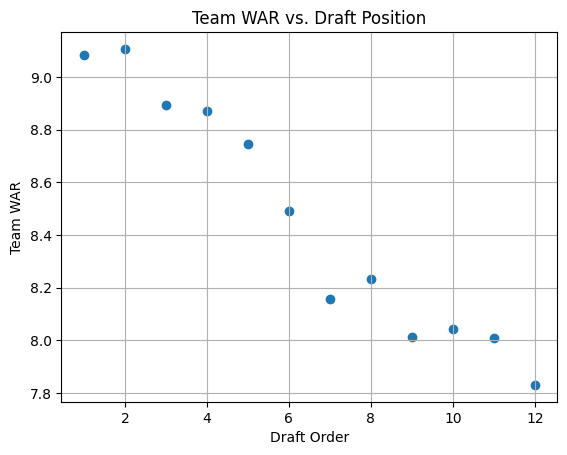

In [108]:
ranks = rank_teams(teams)
ranks = np.array(ranks)
x = np.linspace(1, N_TEAMS, N_TEAMS)

plt.figure()
plt.grid()
plt.scatter(x, ranks)
plt.xlabel("Draft Order")
plt.ylabel("Team WAR")
plt.title("Team WAR vs. Draft Position")
plt.show()

# Position Rank Lookup (TESTING)

In [41]:
pos = 'RB'
pos_war_df = war_df[war_df['position'] == pos]
pos_war_df = pos_war_df.reset_index(drop = True)
pos_war_df.head(50)

,player_display_name,position,n_games,mu,sigma,wpa,war
0,Austin Ekeler,RB,16,22.731251,8.369044,0.236156,3.778489
1,Christian McCaffrey,RB,16,21.216249,8.457760,0.214164,3.426629
2,Josh Jacobs,RB,16,20.081249,11.605990,0.195143,3.122288
3,Derrick Henry,RB,15,19.264000,8.395094,0.183079,2.746182
4,Saquon Barkley,RB,16,17.750000,7.281913,0.142286,2.276578
5,Tony Pollard,RB,15,16.460001,9.784056,0.129782,1.946734
6,Nick Chubb,RB,16,16.137501,7.023965,0.116199,1.859184
7,Joe Mixon,RB,13,17.053846,11.694878,0.137686,1.789915
8,Aaron Jones,RB,16,15.050000,7.900554,0.091159,1.458549
9,Rhamondre Stevenson,RB,16,14.743750,7.597365,0.089989,1.439825


# Testing

In [5]:
df_2022 = nfl.import_pbp_data([2022])
df_players = nfl.import_rosters([2022])
df_teams = nfl.import_team_desc()

print(df_players.columns)

2022 done.
Downcasting floats.
Index(['season', 'team', 'position', 'depth_chart_position', 'jersey_number',
       'status', 'player_name', 'first_name', 'last_name', 'birth_date',
       'height', 'weight', 'college', 'player_id', 'espn_id', 'sportradar_id',
       'yahoo_id', 'rotowire_id', 'pff_id', 'pfr_id', 'fantasy_data_id',
       'sleeper_id', 'years_exp', 'headshot_url', 'ngs_position', 'week',
       'game_type', 'status_description_abbr', 'football_name', 'esb_id',
       'gsis_it_id', 'smart_id', 'entry_year', 'rookie_year', 'draft_club',
       'draft_number'],
      dtype='object')


In [6]:
df_players[df_players['position'] == 'K']

,season,team,position,depth_chart_position,jersey_number,status,player_name,first_name,last_name,birth_date,...,game_type,status_description_abbr,football_name,esb_id,gsis_it_id,smart_id,entry_year,rookie_year,draft_club,draft_number


In [64]:
# Filter to only the data needed for fantasy football
df_2022 = df_2022[df_2022["season_type"] == "REG"]
df_2022 = df_2022[df_2022["week"] <= 17]


In [66]:
# Add team info
df_2022 = df_2022.merge(df_teams[["team_abbr", "team_color"]], left_on="posteam", right_on="team_abbr")

In [68]:
stats = ["passing_yards", "pass_touchdown", "interception", "fumble_lost", "rushing_yards", "rush_touchdown", "receiving_yards", "touchdown"]
stat_dict = dict()
for s in stats:
    stat_dict[s] = "sum"
    
df_agg = (
    df_2022.groupby(["name", "team_abbr", "team_color", "week"], as_index=False)
    .agg(stat_dict)
)

In [69]:
df_agg[df_agg["name"] == "J.Allen"]

,name,team_abbr,team_color,week,passing_yards,pass_touchdown,interception,fumble_lost,rushing_yards,rush_touchdown,receiving_yards,touchdown
886,J.Allen,BUF,#00338D,1,297.0,3.0,2.0,0.0,56.0,1.0,297.0,4.0
887,J.Allen,BUF,#00338D,2,317.0,4.0,0.0,0.0,10.0,0.0,317.0,4.0
888,J.Allen,BUF,#00338D,3,400.0,2.0,0.0,1.0,47.0,0.0,400.0,2.0
889,J.Allen,BUF,#00338D,4,213.0,1.0,1.0,0.0,70.0,1.0,213.0,2.0
890,J.Allen,BUF,#00338D,5,424.0,4.0,1.0,1.0,42.0,0.0,424.0,4.0
891,J.Allen,BUF,#00338D,6,329.0,3.0,0.0,1.0,32.0,0.0,329.0,3.0
892,J.Allen,BUF,#00338D,8,218.0,2.0,2.0,0.0,49.0,0.0,218.0,2.0
893,J.Allen,BUF,#00338D,9,205.0,0.0,2.0,0.0,86.0,2.0,205.0,2.0
894,J.Allen,BUF,#00338D,10,330.0,1.0,2.0,1.0,84.0,0.0,330.0,2.0
895,J.Allen,BUF,#00338D,11,197.0,1.0,0.0,0.0,7.0,0.0,197.0,1.0
